In [1]:
# %% import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
max_features = 10000 
maxlen = 100  

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)  
x_test = pad_sequences(x_test, maxlen=maxlen)

word_index = imdb.get_word_index()

reverse_word_index = {index + 3: word for word, index in word_index.items()}
reverse_word_index[0] = "<PAD>" 
reverse_word_index[1] = "<START>" 
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i, "?") for i in encoded_review])

random_indices = np.random.choice(len(x_train), size=3, replace=False)
for i in random_indices:
    print(f"Yorum: {decode_review(x_train[i])}")
    print(f"Etiket: {y_train[i]}")
    print()

Yorum: the historical inaccuracies of the film are not as gross and offensive as in u <UNK> which changes british <UNK> to american ones but you still walk away feeling a little slimy really the germans in this film do nothing but admire the americans between battle scenes how sad unnecessary i'd just like to say to the writers it's obvious to many of us that you can't capture real people with real problems under real pressure and that you've taken some very well tested <UNK> lucky for you there will always be <UNK> <UNK> to appreciate your sugar <UNK> tripe
Etiket: 0

Yorum: w i officer is in a hospital toward the close of the war suffering from shell shock and complete <UNK> without any idea of his name origin or anywhere he belongs he proves to be a very wealthy established man when he <UNK> he will not remember the years before the war br br but there the <UNK> <UNK> end br br my <UNK> thanks to all who <UNK> in the movie particularly the actors ian <UNK> alan bates ann <UNK> what 

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_size, heads, dropout_rate=0.3):
        super(TransformerBlock, self).__init__()
        
        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_size)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)  # 1. normalizasyon katmanimiz
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)  # 2. normalizasyon katmanimiz
        
        self.feed_forward = models.Sequential([
            layers.Dense(embed_size*4, activation="relu"),
            layers.Dense(embed_size)
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, x, training):
        attention = self.attention(x, x)
        x = self.norm1(x + self.dropout1(attention, training=training))
        feed_forward = self.feed_forward(x)
        return self.norm2(x + self.dropout2(feed_forward, training=training))

In [4]:
class TransformerModel(models.Model):
    def __init__(self, num_layers, embed_size, heads, input_dim, output_dim, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = layers.Embedding(input_dim=input_dim, output_dim=embed_size)
        self.transformer_blocks = [TransformerBlock(embed_size, heads, dropout_rate) for _ in range(num_layers)]
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(output_dim, activation="sigmoid")
        
    def call(self, x, training):
        x = self.embedding(x)
        for transformer in self.transformer_blocks:
            x = transformer(x, training)
        x = self.global_avg_pooling(x)
        x = self.dropout(x, training=training)
        
        return self.fc(x)

In [5]:
num_layers = 4  
embed_size = 64
num_heads = 4  
input_dim = max_features
output_dim = 1  
dropout_rate = 0.1

model = TransformerModel(num_layers, embed_size, num_heads, input_dim, output_dim, dropout_rate)

model.build(input_shape=(None, maxlen))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(x_train, y_train, epochs=2, batch_size=256, validation_data=(x_test, y_test))

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  640000    
                                                                 
 transformer_block (Transfor  multiple                 99712     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  multiple                 99712     
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  multiple                 99712     
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  multiple                 99712     
 ormerBlock)                                     

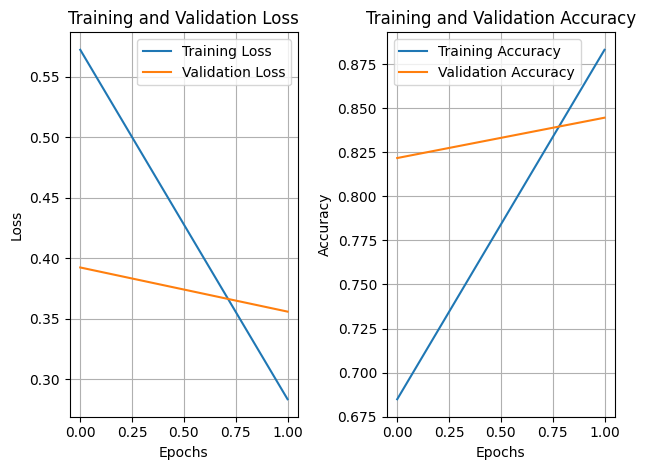

In [6]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
def predict_sentiment(model, text, word_index, maxlen):
    encoded_text = [word_index.get(word, 0) for word in text.lower().split()] 
    padded_text = pad_sequences([encoded_text], maxlen=maxlen)  
    prediction = model.predict(padded_text) 
    return prediction[0][0]

word_index = imdb.get_word_index()

user_input = input("Enter a movie review: ")
sentiment_score = predict_sentiment(model, user_input, word_index, maxlen)

if sentiment_score > 0.5:
    print(f"Prediction result: Positive -> score: {sentiment_score}")
else:
    print(f"Prediction result: Negative -> score: {sentiment_score}")

Enter a movie review:  This film was an enjoyable experience! The story, while simple, kept me engaged, and the characters had their own charm. The visuals were decent, and the soundtrack fit the mood well. It may not be a masterpiece, but it offers light entertainment. 


1/1 [==============================] - 1s 574ms/step
Prediction result: Positive -> score: 0.6829627752304077
